In [1]:
# Enable current type hints for older Python version (<3.10) 
from __future__ import annotations

from typing import Literal  # Requires Python 3.8+
import boto3
import pandas as pd
import pyarrow.parquet as pq
import numpy as np
import numpy.typing as npt
import seaborn as sns
import matplotlib.pyplot as plt
import pdb
import logging
from pathlib import Path
from dotenv import dotenv_values

logger = logging.getLogger(__name__)

In [2]:
config = dotenv_values(".env")

BUCKET = config['BUCKET']
PREPROCESSING_INPUT_KEY = config['PREPROCESSING_INPUT_KEY']

In [3]:
# Create local directories needed, if they don't exist yet
try:
    Path('data').mkdir(exist_ok=False)
except FileExistsError:
    logger.info('Directory already exist')

In [4]:
%%capture hide_output

# Log into AWS (default account), if not already authenticated
!aws s3 ls || aws sso login

# Read data
See the "data-pipeline" directory for how to get and persist the data as parquet.

In [5]:
s3 = boto3.client('s3')

PREPROCESSING_INPUT_PATH = 'data/preprocessing_input.parquet'

s3.download_file(
    Bucket=BUCKET, 
    Key=PREPROCESSING_INPUT_KEY,
    Filename=PREPROCESSING_INPUT_PATH,
)

df = pq.read_table(PREPROCESSING_INPUT_PATH)
df = df.to_pandas()
df.iloc[1:3, :]

,replied_to,sender,body,timestamp
183cb6c70075704b,False,Anthem-healthspendingaccounts@mail2.anthem.com,[http://images.myhealthyfinances.com/EloquaIma...,1665565214000
183ca91acbdcd4f8,False,FloTechnologies <no-reply@meetflo.com>,\n\n\n\n\nWarning:\r\n Low Battery\r\n \...,1665550886000


In [6]:
len(df)

26695

# Clean and transform data

## Drop rows
ToDo: Do this as part of the data pipeline.

In [7]:
# Drop emails frowarded from my other inbox
df.loc[
    df.sender.str.contains('loeberthomas@yahoo.com'), 
    'replied_to'
] \
.value_counts()

False    388
Name: replied_to, dtype: int64

In [8]:
df = df.loc[
    ~df.sender.str.contains('loeberthomas@yahoo.com'),
    :
]

In [9]:
# Drop emails whith empty body
df = df.loc[
    df.body.map(len) > 0,
    :
]

## Text preprocessing
In this step, we put the data in the format required by the blazing text algorithm.

In [11]:
import nltk
nltk.download("punkt")

def create_target(s):
    """Target as required by Blazing Text IF USING PLAINTEXT FORMAT."""
    label = "reply" if s == True else "no_reply"
    return f'__label__{label}'

# Convert training data into right format for tensorflow
def strip_non_ascii_chars(string_: str) -> str:
    return string_.encode('ascii', errors='ignore').decode()

def replace_chars_for_csv(string_: str) -> str:
    return string_.replace('\n', ' ') \
        .replace(',', ' ')

def tokenize(s):
    token_list = nltk.word_tokenize(s)
    return ' '.join(token_list)

# label as required by Blazing Text IF USING PLAINTEXT FORMAT
df['label'] = df.replied_to.astype(int)

df.label.value_counts()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tloeb\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


0    24234
1      261
Name: label, dtype: int64

In [12]:
df['feature'] = df.body.map(strip_non_ascii_chars) \
    .map(replace_chars_for_csv) \
    .map(tokenize)

In [13]:
df[['feature', 'label']].head(3)

,feature,label
183cbf647a8af438,Good morning families - The technician is here...,0
183cb6c70075704b,[ http : //images.myhealthyfinances.com/Eloqua...,0
183ca91acbdcd4f8,Warning : Low Battery Warning : Low Battery Vi...,0


In [14]:
assert df.isnull().sum().sum() == 0
assert df.feature.str.contains(',').sum() == 0
assert df.feature.str.contains('\n').sum() == 0

# Split data
Since this data has a time component, we don't randomly split the data. Instead, we make sure to assess the model performance on data that is newer than any data the model has seen during training. This more closely mirrors the situation in production.

Note that we have to follow this principle twice: We make sure that the validation data is newer than the training data, and that the test data is newer than the validation data.

In [15]:
# Specify split proportion, then identify corresponding timestamp and split.
TRAIN_PROPORTION = 0.75
VAL_PROPORTION = 0.1
test_proportion = 1 - TRAIN_PROPORTION - VAL_PROPORTION
assert test_proportion > 0
assert test_proportion < 1

train_cutoff = np.quantile(df.timestamp, q=TRAIN_PROPORTION)
val_cutoff = np.quantile(df.timestamp, q=TRAIN_PROPORTION+VAL_PROPORTION)

def split_dataset(ts):
    if ts < train_cutoff:
        return 'train'
    elif ts > val_cutoff:
        return 'test'
    else:
        return 'val'
    

df['split'] = df.timestamp.map(split_dataset)

counts = df.groupby(['split', 'label']).feature \
    .count() \
    .reset_index()
counts

,split,label,feature
0,test,0,3632
1,test,1,43
2,train,0,18176
3,train,1,195
4,val,0,2426
5,val,1,23


In [16]:
# Perform actual split
df_train = df.loc[df.split == 'train', ['label', 'feature']]
df_val = df.loc[df.split == 'val', ['label', 'feature']]
df_test = df.loc[df.split == 'test', ['label', 'feature']]

## Save raw data for Ludwig

In [17]:
# Set to `coerce` if missing values weren't dropped
ERROR_STRATEGY: Literal['coerce', 'raise'] = 'raise'  

# Convert timestamp from unix epoch to datetime, so we can use Ludwig's datetime
# splitter. (Have to manually convert to string, because otherwise to_json() uses
# unix epoch again.)
# Todo: leverage pandas-stubs to fix Pylance's static analysis errors
timestamp_as_date: pd.Series[str] = pd.to_datetime(
        df.timestamp, 
        unit='ms',
        errors=ERROR_STRATEGY,
        origin='unix',    
    ) \
    .astype(dtype=str, errors=ERROR_STRATEGY)

df_ludwig: pd.DataFrame = df.drop('timestamp', axis='columns') \
    .assign(time_received=timestamp_as_date)

# Ludwig's split column expects integer(for manual splitting, since Ludwig's 
# datetime split is not working properly)
df_ludwig['split'] = df_ludwig.split \
    .map(
        {
            'train': 0,
            'val': 1,
            'test': 2,
        }
    )


# 1) Full samle
df_ludwig_str: str = df_ludwig.to_json(orient='records', lines=True)

local_path = Path('data/model-input-ludwig.jsonl')    
with local_path.open('w') as f:
    f.write(df_ludwig_str)

In [18]:
# 2) Smaller subsample (for quicker iteration)
# Note: Could also achieve this in Ludwig's config by specifying
# `preprocessing:\n  sample_ratio: 0.3`. But wouldn't allow stratifying.
from sklearn.utils import resample

SUBSAMPLE_SIZE: int = 200

df_ludwig_small: pd.DataFrame = resample(
        df_ludwig,
        replace=False, 
        n_samples=SUBSAMPLE_SIZE,
        random_state=1,
        stratify=df['replied_to'],  # To ensure enough positive examples are included
    ) 


# Write JSONLines
with open('data/model-input-ludwig-small.jsonl', 'w') as f:
    f.write(
        df_ludwig_small.to_json(orient='records', lines=True)
    )

In [21]:
# Write pickle
df_ludwig_small.to_pickle('data/model-input-ludwig-small.pickle')

## Oversample minority class
Most emails do not elicit a reply (see barplot below); therefore, maximizing accuracy would probably be misleading. It's easy to get high accuracy simply by predicting that no email will receive a reply.

However, since the blazing text algorithm does not allow specifying a different metric to optimize (e.g., F1-score), I simply transform this problem into a balance classification problem by randomly oversampling emails that elicited a reply.

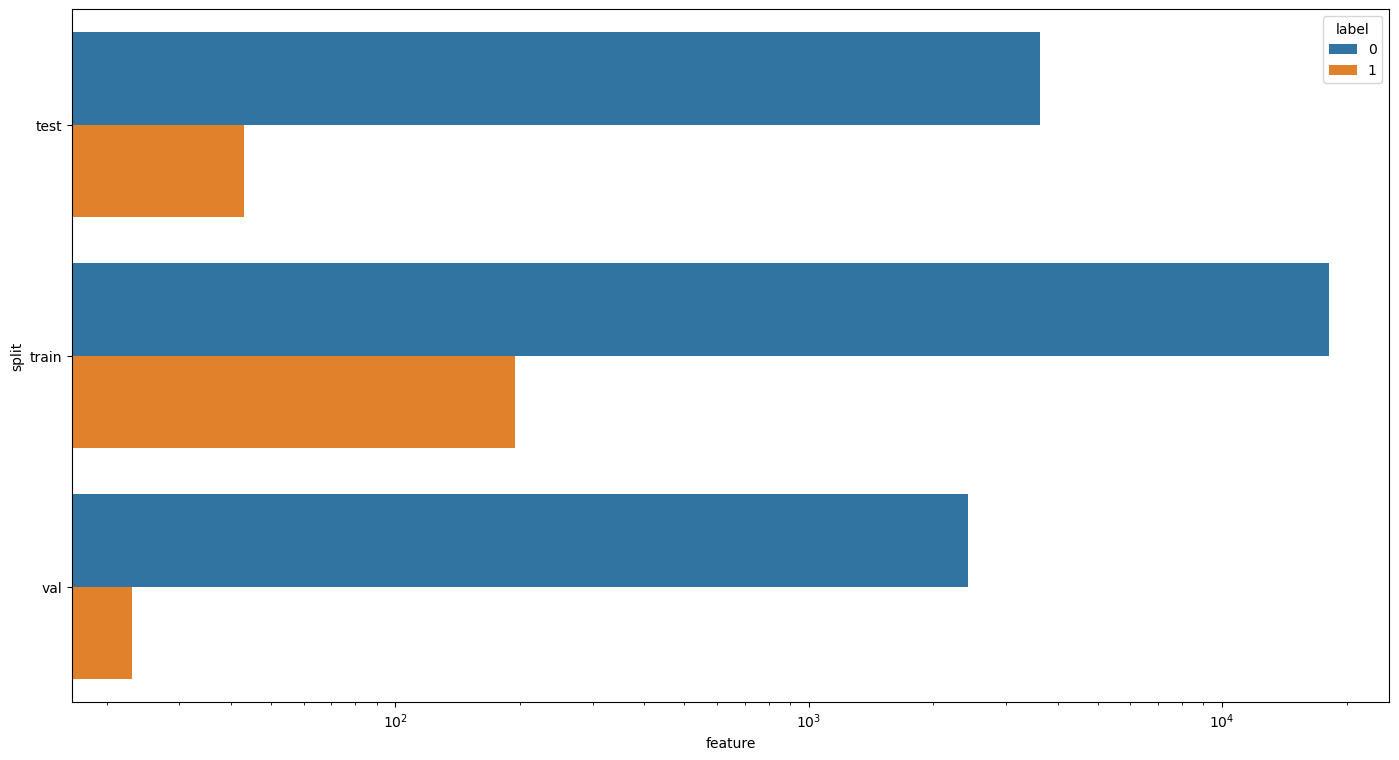

In [18]:
p = sns.barplot(data=counts, y='split', x='feature', hue='label', orient='h', errwidth=0)
p.set_xscale('log')
plt.show()

In [19]:
# !pip install imblearn --quiet

In [20]:
from imblearn.over_sampling import RandomOverSampler

def oversample(df: pd.DataFrame) -> pd.DataFrame:
    max_label_count = df.label \
        .value_counts() \
        .max()

    ros = RandomOverSampler(
        random_state=1, 
        sampling_strategy={
            0: max_label_count,
            1: max_label_count,
        }    
    )
    X, y = ros.fit_resample(X=df[['feature']], y=df[['label']])

    df = pd.DataFrame(
        {
            'label': y.label,
            'feature': X.feature,
        }
    )
    return df

df_train = oversample(df_train)
df_train.label.value_counts()

df_val = oversample(df_val)
df_val.label.value_counts()

# For explainability, use only a subset of test. TODO: oversample replied-tos.
df_explain = df_test.sample(
    n=20, 
    random_state=0, 
)

We can see that both classes now appear in the same number in both the training and validation data.

# Write input data
Write data in plain text, using pd.to_csv and separating by whitespace. After writing the different data sets, we upload them to S3.

In [21]:
# Write augmented manifest file/jsonl
# ===================================
# (For training in pipe mode)

# Todo: Use sagemaker experiments & model registry for tracking data versions
def write_jsonlines_to_s3(
    df: pd.DataFrame, destination_folder: str, add_num_classes: bool = False
) -> None:
    """
    For test data that will be inputed into batch prediction, set 
    `add_num_classes` to True. This will add an extra field to each row that 
    tells prediction to output the probability for all classes (which in turn 
    makes prediction code more straightforward and reusable.
    """
    logger.debug(
        f'Breakdown for {destination_folder}:\n{df.label.value_counts()}'
    )
    
    if add_num_classes:
        num_classes: int = df.label.nunique()
        df = df.assign(k=num_classes)
    
    # Todo: Start using `source` instead of `label` further upstream
    df_jsonl = df.rename(columns={'feature': 'source'}) \
        .to_json(orient='records', lines=True)

    local_path = Path('data/model-input.jsonl')    
    with local_path.open('w') as f:
        f.write(df_jsonl)
                
    s3.upload_file(
        Filename=str(local_path),
        Bucket=BUCKET,
        Key=f'{destination_folder}/model-input.jsonl'
    )
    
    print(f'Data uploaded to {destination_folder}/model-input.jsonl')
    
    
write_jsonlines_to_s3(
    df_train[['feature', 'label']], 
    destination_folder='train'
)
write_jsonlines_to_s3(
    df_val[['feature', 'label']], 
    destination_folder='validation'
)
write_jsonlines_to_s3(
    df_test[['feature', 'label']], 
    destination_folder='test',
    add_num_classes=True
)
write_jsonlines_to_s3(
    df_explain, 
    destination_folder='explainability-input'
)

Data uploaded to train/model-input.jsonl
Data uploaded to validation/model-input.jsonl
Data uploaded to test/model-input.jsonl
Data uploaded to explainability-input/model-input.jsonl


In [22]:
# Write plain text
# ================
# (For training in file mode, e.g. for debugging etc)

def write_plaintext_to_s3(df: pd.DataFrame, destination_folder: str) -> str:
    logger.debug(
        f'Breakdown for {destination_folder}:\n{df.label.value_counts()}'
    )
    # Format for label differs between pipe and file mode
    df['label'] = df.label.map(_create_text_label)
           
    path_local = 'data/model-input.csv'
    
    # Using .to_csv() with a whitespace as a separator creates a normal text file
    df[['label', 'feature']].to_csv(
        path_local,
        index=False, 
        header=False, 
        sep=' ',
    )
    
    s3.upload_file(
        Filename=path_local,
        Bucket=BUCKET,
        Key=f'{destination_folder}/model-input.csv'
    )
    print(f'{path_local} uploaded to {destination_folder}.')
    

def _create_text_label(s):
    """Convert 0/1 label to text"""
    label = "reply" if s else "no_reply"
    return f'__label__{label}'


write_plaintext_to_s3(df_train, destination_folder='plaintext/train')
write_plaintext_to_s3(df_val, destination_folder='plaintext/validation')
write_plaintext_to_s3(df_test, destination_folder='plaintext/test')

data/model-input.csv uploaded to plaintext/train.
data/model-input.csv uploaded to plaintext/validation.
data/model-input.csv uploaded to plaintext/test.


In [23]:
# Persist test data for other notebook
import pickle
with open('df_test.pickle', 'wb') as f:
    pickle.dump(obj=df_test, file=f)

In [24]:
from datetime import datetime
print(f'Finished at {datetime.now()}')

Finished at 2022-12-04 09:47:42.070876
